In [1]:
#import data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

import glob
import sys

sys.path.append('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/')
import pymlp.flocculation as flo

root = "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/"

#strain maps 
new_wild_isolate_map = root + "internal data/final wild strain map.xlsx"
segregant_map = root + "internal data/segregant_strains_map.xlsx"

# Segregants on EMM 

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

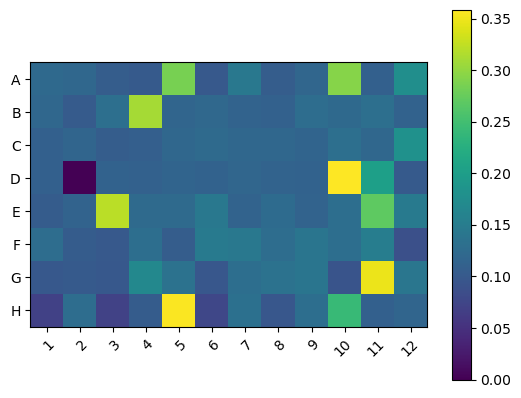

In [2]:
#strain data folders
folder_seg_emm= "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/internal data/flocculation_plate_reader_data/Segregants_EMM"
segregants_emm = flo.folder_to_results(folder_seg_emm,10, 37, segregant_map, groupby="Position")
flo.heatmap_from_df(segregants_emm)

# Compare with filtering measurements

In [3]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/filtering_results.csv separator \
filtering_results = pd.read_csv(root + "Bence folder/Phenotypes/filtering_results.csv", sep="\t")
#groupby Strain and take mean %flocc
filtering_results = filtering_results.groupby("Strain").mean()

In [4]:
strains = pd.read_excel(segregant_map, header=None)
#RENAME COLUMNS 1-12, INDICES A-H
strains = strains.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains = strains.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})


In [5]:
#loop through position in CV_df and get the strain from strains
strain_list = []
for i in segregants_emm.index:
    #get row and column by splitting the position as the first character being the index and the rest being the column
    row = i[0]
    column = i[1:]
    #get the strain from strains
    strain = strains.loc[row, column]
    strain_list.append(strain)
#add the strain list to CV_df
segregants_emm["Strain"] = strain_list
#merge CV_df with filtering_results on Strain
CV_df_final_seg = segregants_emm.merge(filtering_results, on="Strain")
#remove any strain that starts with JB
CV_df_final_seg = CV_df_final_seg[~CV_df_final_seg["Strain"].str.startswith("JB")]


Text(0.05, 0.9, 'p-value: 1.35e-15')

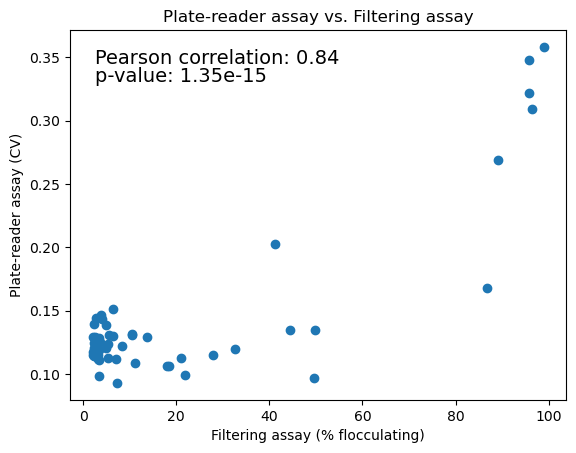

In [6]:
#plot CV vs %flocc
import scipy.stats as st
fig, ax = plt.subplots()
ax.scatter(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])
ax.set_xlabel("Filtering assay (% flocculating)")
ax.set_ylabel("Plate-reader assay (CV)")

#make it pretty and put pearson correlation on the plot
ax.set_title("Plate-reader assay vs. Filtering assay")
#print pearson correlation
ax.text(0.05, 0.95, "Pearson correlation: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[0], 2)), transform=ax.transAxes, fontsize=14, verticalalignment='top')
#print p-value
ax.text(0.05, 0.9, "p-value: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[1], 17)), transform=ax.transAxes, fontsize=14, verticalalignment='top')




/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/pymlp/flocculation.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


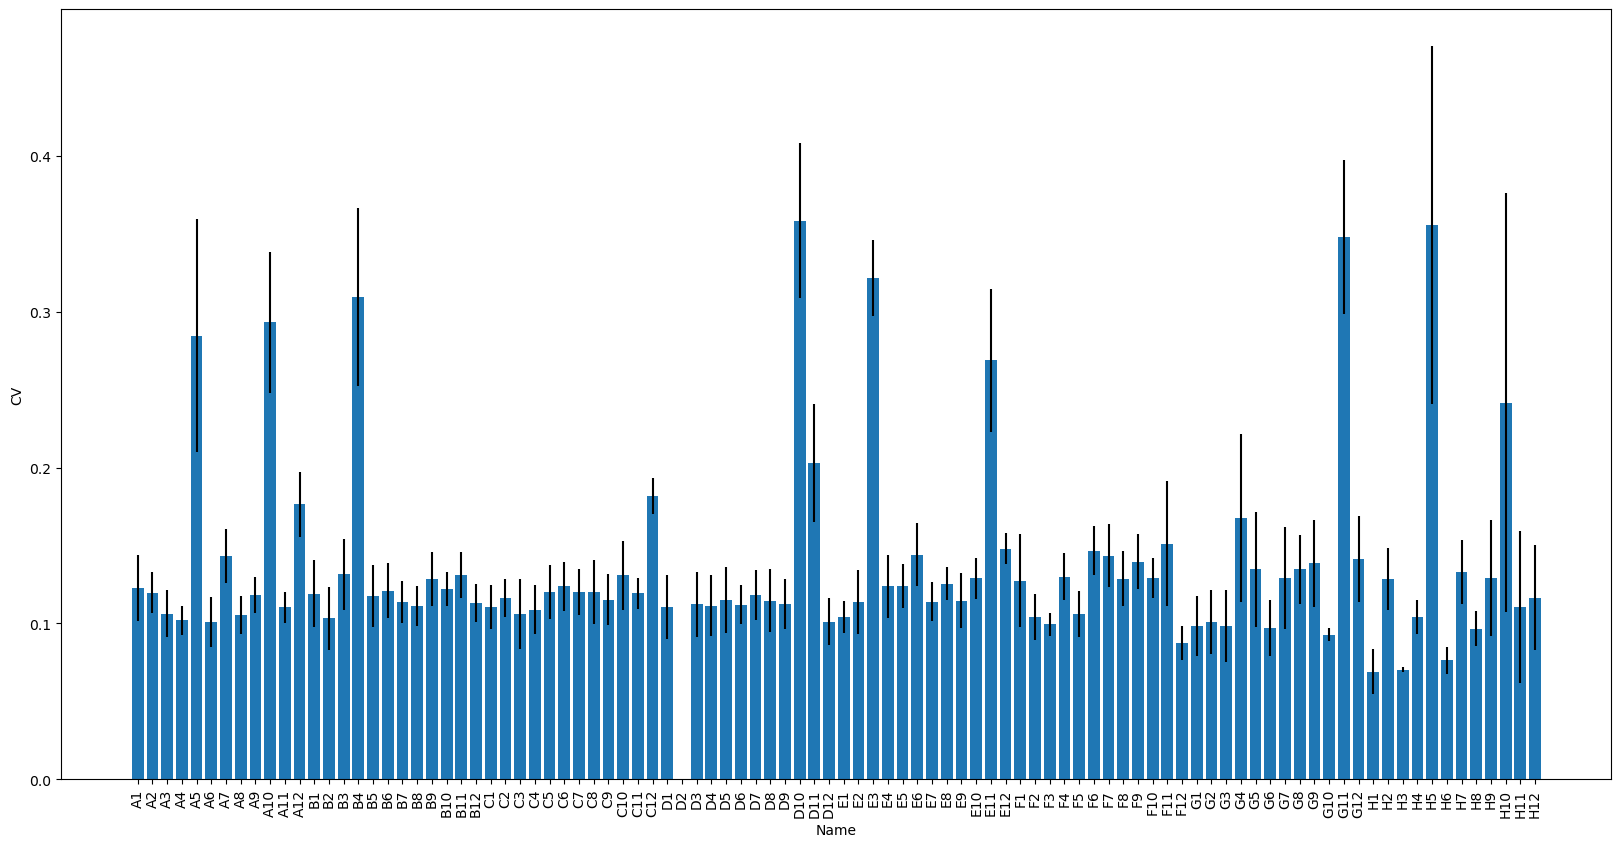

In [7]:
flo.barchart_from_df(segregants_emm)


# Repeat for wild isolates

In [8]:
strains_wi = pd.read_excel(root + "internal data/final wild strain map.xlsx",header=None)
#RENAME COLUMNS 1-12, INDICES A-H
strains_wi = strains_wi.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains_wi = strains_wi.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})
strains_wi 


,1,2,3,4,5,6,7,8,9,10,11,12
A,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB759,JB50
B,JB759,JB50,JB1110,JB1117,JB1154,JB1171,JB1174,JB1180,JB1197,JB1205,JB1206,JB759
C,JB50,JB759,JB1207,JB22,JB4,JB758,JB760,JB762,JB837,JB838,JB840,JB50
D,JB759,JB841,JB842,JB845,JB846,JB848,JB852,JB853,JB854,JB858,JB862,JB759
E,JB50,JB864,JB869,JB870,JB871,JB872,JB873,JB874,JB875,JB878,JB879,JB50
F,JB759,JB884,JB899,JB900,JB902,JB910,JB913,JB914,JB916,JB917,JB918,JB759
G,JB50,JB929,JB930,JB931,JB934,JB938,JB939,JB942,JB943,JB953,EMPTY,JB50
H,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB759,JB50,JB759


(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

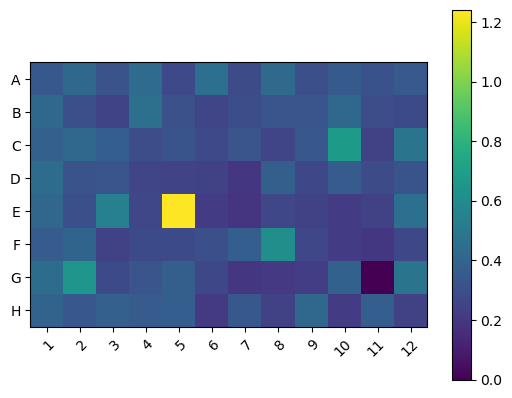

In [9]:
#strain data folders
folder_wi_emm= "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/internal data/flocculation_plate_reader_data/Wild Isolates_EMM"
wi_map = root + "internal data/final wild strain map.xlsx"
wi_emm = flo.folder_to_results(folder_wi_emm,[9,9,10,10,10], 82, wi_map, groupby="Position")
flo.heatmap_from_df(wi_emm)

/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/pymlp/flocculation.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


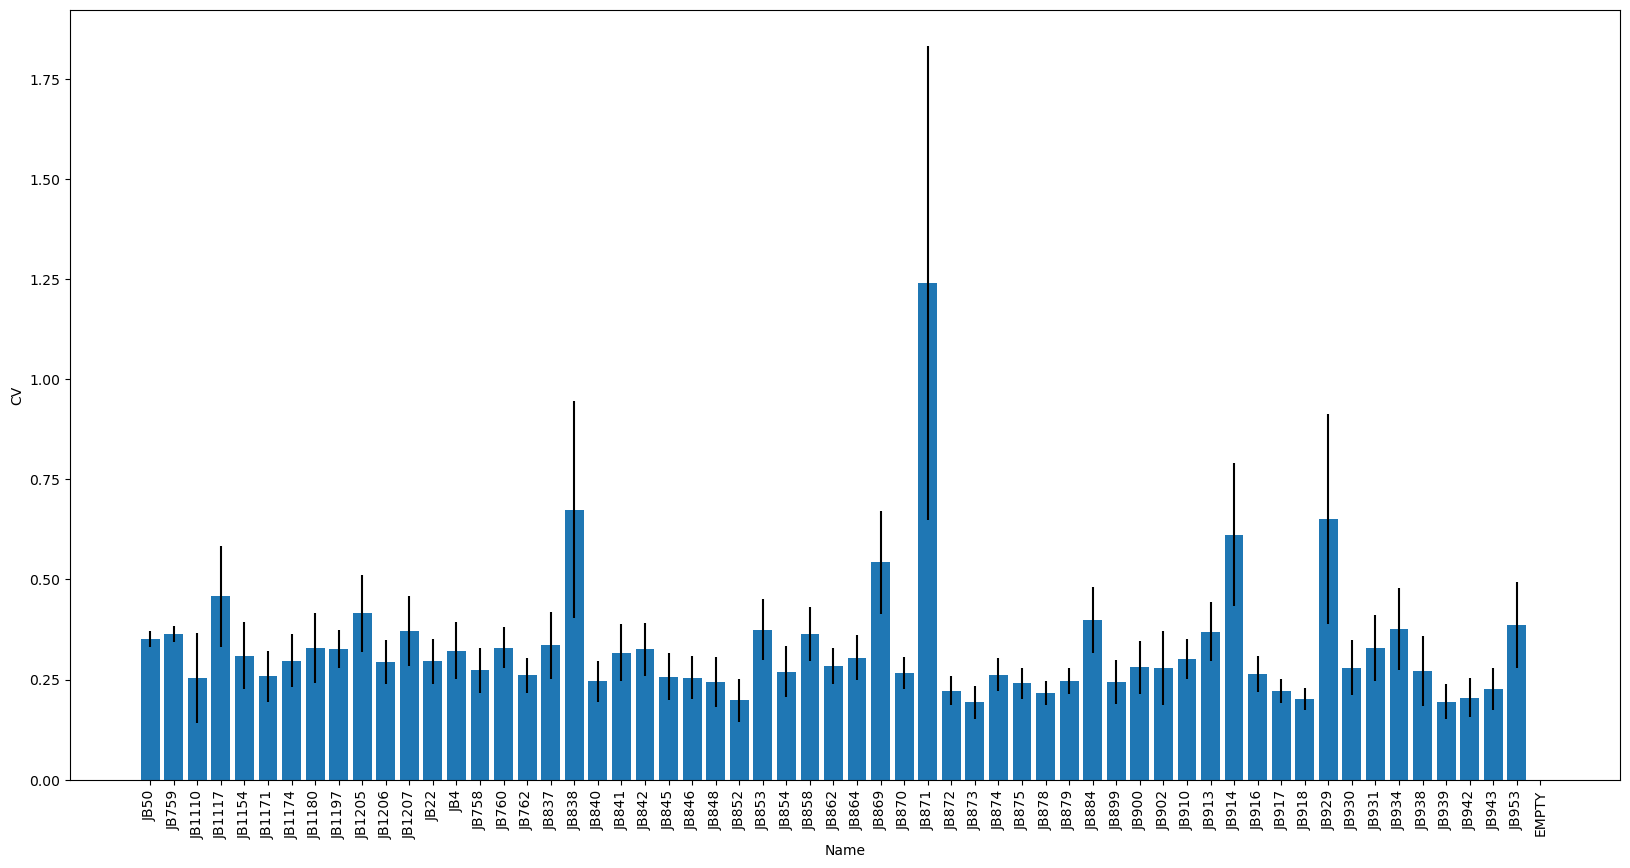

In [10]:
wi_emm = flo.folder_to_results(folder_wi_emm,[9,9,10,10,10], 82, wi_map, groupby="Strain")
flo.barchart_from_df(wi_emm)

# Rep for wild isolates YES

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

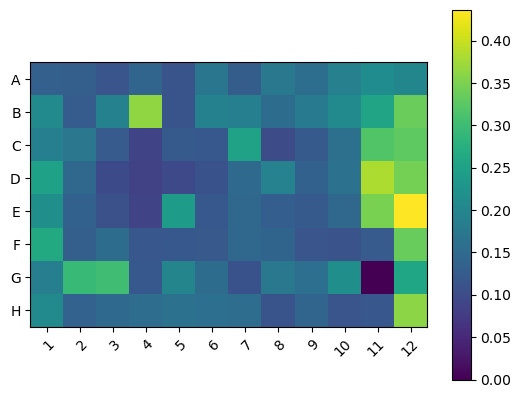

In [11]:
folder_wi_yes= "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/internal data/flocculation_plate_reader_data/Wild Isolates_YES"
wi_map = root + "internal data/final wild strain map.xlsx"
wi_yes = flo.folder_to_results(folder_wi_yes,10, 82, wi_map, groupby="Position")
flo.heatmap_from_df(wi_yes)

/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/pymlp/flocculation.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.index, rotation=90)


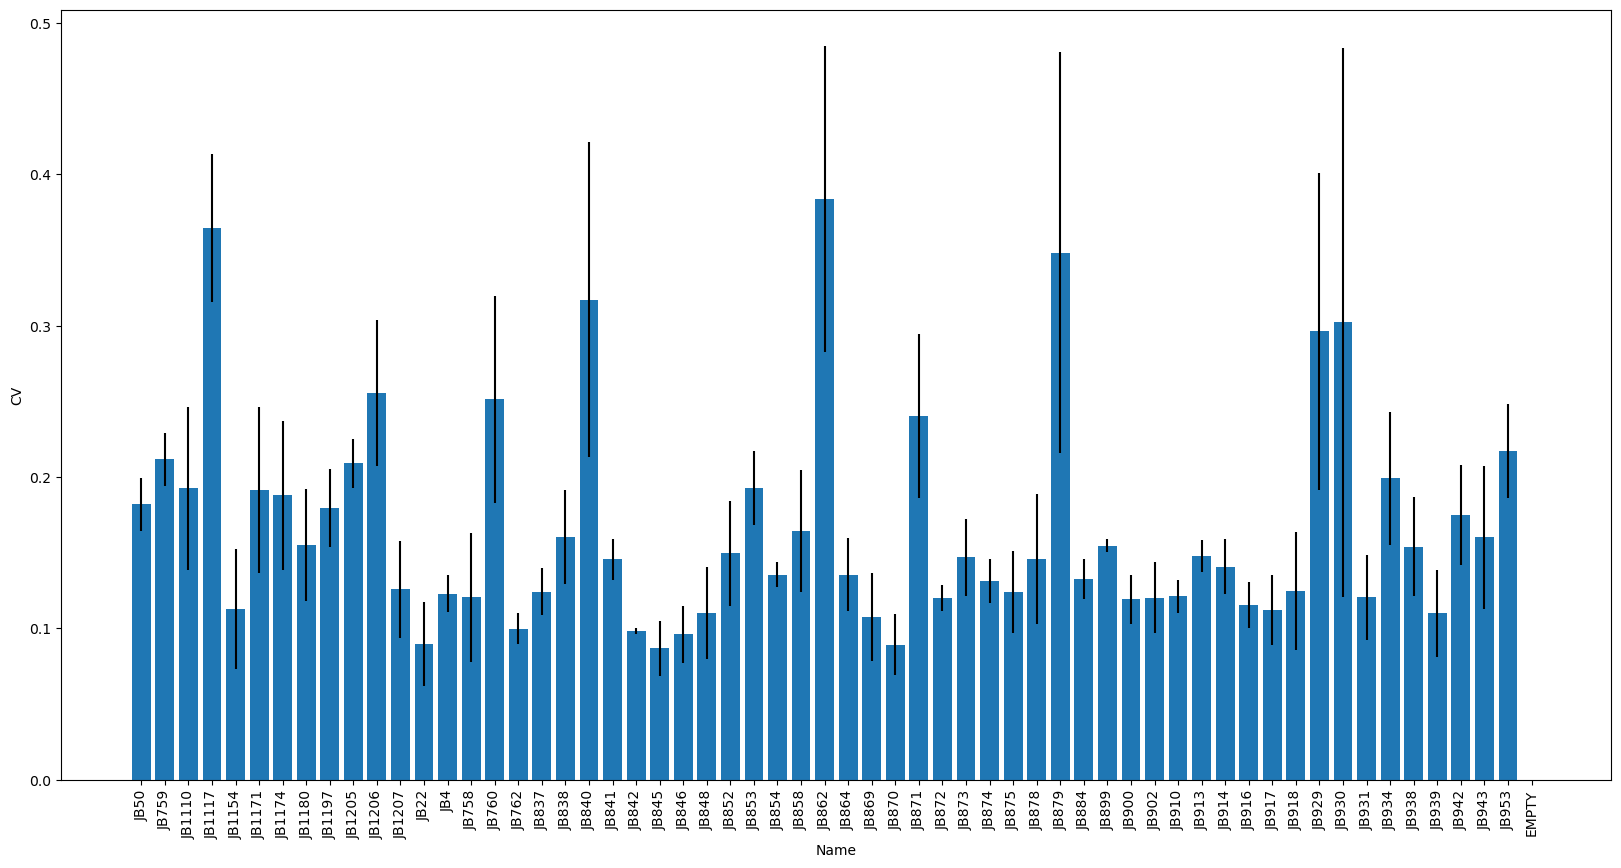

In [12]:
wi_yes = flo.folder_to_results(folder_wi_yes,10, 82, wi_map, groupby="Strain")
flo.barchart_from_df(wi_yes)